### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

# Multi layer Perceptron

This project is based on the [AI for beginners](https://github.com/microsoft/AI-For-Beginners) course from microsoft and uses the same framework to build the network, although the derivatives are calculated in a different way, following my own mathematical resolution of an N-layered perceptron. 

For building a perceptron framework we need 3 elements, in the form of classes:

- Hidden layer
- Output layer
- Stackable network framework

Both layers have a linear transformation forward pass, which outputs a transformation based on the weights and bias of the model. Then the hidden layer has an activation function forward pass which applies whatever activation function you choose to the layer, and the output layer has an activation function forward pass which is always a softmax to output probabilities. 
Both of them have a backward pass to calculate the derivatives of the weights and bias and an update method to update them.

The stackable network framework is the framework that allows us to stack multiple hidden layers and an output layer in our perceptron model and perform forward and backward passes on all of the layers automatically. 

The loss function is a cross entropy function and the output layer uses a softmax activation function, since that is what I assumed for my mathematical resolution, but any hidden layer activation function can be used. In particular I will be using tanh since it is a simple function to differentiate. 

## Vector batches for SGD

MNIST digits are arrays of shape (784,)

To use SGD we will use a batch of input vectors instead of a single one. A batch of vectors is an array of shape (b,784)

The reasoning was done with column vectors (784,) so this new approach requires us to transpose the matrix multiplications.
This involves changing the order and then transposing both vector and matrix. (the vector is already transposed)

By changing the order of all terms and transposing the matrix at __init__ (changing input and output dimensions) we achieve
the same matrix multiplications, now with vectors of shape (,784) for forward and backward passes. 

Now that we have the multiplication for row vectors, we have to accomodate for a batch of vectors. The result of a linear 
transformation of a batch is a matrix, where every row is the result of the transformation of one vector of the batch. Now the bias needs to be a vector of shape (1,nout), and numpy understands to add it in every row of the resulting matrix since it is a row vector.

Vector-vector multiplication when changing to batch matrix-batch matrix multiplication is simply the sum of all pairs of vector vector multiplication. 
If the batch has 4 vectors, instead of (1,784) each vector is a matrix (4,784) and their multiplication is a sum over all 
4 pairs of vector-vector multiplications. 
In the case of the bias, they don't sum 
themselves, the derivative of the bias is a (b,...) matrix so we must sum over axis=0 to obtain the proper shape.

This means that all operations can stay the same for a batch-batch multiplication as they were for a single vector when doing forward and backward passes.


In a batch of b vectors, the dimensions of the vectors for layer n are

Forward
    - input vector   (b,m(n-1))
    - Weights        (m(n-1),m(n))
    - bias           (1,m(n))
    - output         (b,m(n))

Backward
    - derivative activation  (b,m(n))
    - A coefficient          (b,m(n-1))
    - A "previous"(n+1)      (b,m(n))
    - Weights derivatives    (m(n-1),m(n))
    - bias derivatives       (b,m(n-1))


## Loading the dataset

In [1]:
import gzip
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.datasets import make_classification
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random
import time
import os

#The mnist.pkl.gz file was donwloaded manually
with gzip.open('mnist.pkl.gz', 'rb') as mnist_pickle:
    #MNIST = pickle.load(mnist_pickle,encoding='latin1')
    training_data, validation_data, test_data = pickle.load(mnist_pickle,encoding='latin1')
#MNIST = pd.read_pickle('mnist.pkl.gz',compression='gzip')

# Split into train and test dataset
#train_x, test_x = np.split(MNIST[0], [n*8//10])
#train_labels, test_labels = np.split(Y, [n*8//10])

#MNIST is a tuple containing already a set of 50000 (train) and 2 sets of 10000 (validation and test)
#MNIST[i][j][k]
    #i indicates the train 0 validation 1 test 2
    #j indicates array of digits 0 or labels 1
    #k indicates which digit or label 0-49999 0-9999

#training_data[i][j]
    #i indicates array of digits 0 or labels 1
    #j indicates which digit or label 0-49999

## Framework

In [2]:
class Hidden_Layer():
    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (input_dimension,output_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def linear_forward(self,x):
        self.yn_1 = x                       #storing y(n-1) for later
        return np.dot(x,self.W) + self.b    #returns the linear transformation
    
    def activation_forward(self,z):
        y = np.tanh(z)
        self.da = 1-y*y                     #storing a'(n) for layer
        return y                            #tanh squishes values between -1 and 1
    
    def backward(self,A_prev):
        
        Ada = np.multiply(A_prev,self.da)
        
        self.dW = np.matmul(self.yn_1.T,Ada)
        self.db = Ada.sum(axis=0)

        return np.matmul(Ada,self.W.T)
        
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db


In [3]:
class Output_Layer():
    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (input_dimension,output_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def linear_forward(self,x):
        self.yn_1 = x                       #storing y(n-1) for later
        return np.dot(x,self.W) + self.b    #returns the linear transformation
    
    def activation_forward(self,z):        
        #adding a constant >1 in front of z makes small increases in z bring greater increases in p
        zmax = z.max(axis=1,keepdims=True) #this prevents overflow for big z values and does not change p
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        self.p = expz / Z                   #storing p for the backward pass
        return self.p

    
    def backward(self,labels):
        
        #labels is vector of shape (b,)
        
        #I get p from self.p since I stored in the forward pass
        
        #p_of_f = \sum_alpha -(d_gamma_i - p_i)    (b,m(N))
        
        #p is a matrix of shape (b,m(N)) and to transform it into p_of_f I need to iterate over every row based on the order
        #of the labels -> 0th label 0th row, 1st label 1st row
        #and from every row transform the probability matching the label value into p_of_f = p-1
        #the others stay as p_of_f = p
        
        p_of_f = self.p
        for i,lab in enumerate(labels):
            p_of_f[i,lab] -= 1
        
        self.db = p_of_f.sum(axis=0)
        self.dW = np.matmul(self.yn_1.T,p_of_f)

        return np.matmul(p_of_f,self.W.T)
        
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db


In [4]:
class Network:
    def __init__(self):
        self.layers = []
        
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,y):
        for l in self.layers:
            #y = l.linear_forward(y)
            #y = l.activation_forward(y)
            
            y = l.activation_forward(l.linear_forward(y))

        return y                 #returns p
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        #return z               #I don't need backward to return A(1)
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)


## Training a single layer perceptron

The first test we can do is create a simple 1 layer network and train it with a number of batches that covers our training set exactly once. This is sometimes known as a training epoch.

In [5]:
training_x = training_data[0]
training_labels = training_data[1]

net = Network()
#first layer gets training_x.shape[1] as input, output layer gets max(training_labels)+1 as output
net.add(Output_Layer(training_x.shape[1],max(training_labels)+1))

learning_rate = 0.01
batch_size = 10

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Initial accuracy for training data: ",acc)

for i in range(0,len(training_x),batch_size):
    xb = training_x[i:i+batch_size]
    yb = training_labels[i:i+batch_size]
    # forward pass
    p = net.forward(xb)
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Final accuracy for training data: ",acc)

Initial accuracy for training data:  0.0525
Final accuracy for training data:  0.90968


In [6]:
testing_x = test_data[0]
testing_labels = test_data[1]

pred = np.argmax(net.forward(testing_x),axis=1)
acc = (pred==testing_labels).mean()
print("Accuracy for testing data: ",acc)

Accuracy for testing data:  0.9099


This is a single layer perceptron as we did in our previous project, and we can see that now our accuracy is much higher, going from approximately 0.7 to arround 0.9 just by changing the mathematical operations the layer performs to calculate probabilities and its training, but we can still improve by adding more layers. 

## Training a multi layered perceptron



In [7]:
training_x = training_data[0]
training_labels = training_data[1]

net = Network()
#first layer gets training_x.shape[1] as input, output layer gets max(training_labels)+1 as output
#adding a layer with 10 nodes
#the output dimension for one layer and input dimension for the next must be the same
m = 40
n = 40
net.add(Hidden_Layer(training_x.shape[1],m))
net.add(Hidden_Layer(m,n))
net.add(Output_Layer(n,10))#max(training_labels)+1))

learning_rate = 0.01
batch_size = 10

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Initial accuracy for training data: ",acc)

for i in range(0,len(training_x),batch_size):
    xb = training_x[i:i+batch_size]
    yb = training_labels[i:i+batch_size]
    # forward pass
    p = net.forward(xb)
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    
pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Final accuracy for training data: ",acc)

Initial accuracy for training data:  0.08648
Final accuracy for training data:  0.9454


In [8]:
testing_x = test_data[0]
testing_labels = test_data[1]

pred = np.argmax(net.forward(testing_x),axis=1)
acc = (pred==testing_labels).mean()
print("Accuracy for testing data: ",acc)

Accuracy for testing data:  0.9428


We can see the accuracy went up a bit from 0.9 to arround 0.94. The amount of nodes in the hidden layers play a significant role, a higher amount of nodes brings about higher accuracy, at the risk of overfitting.

# Building a Perceptron

Finally, we will build a better framework for our perceptron, simplifying the tasks of creating and training the network by creating a class that aoutomatically builds an N-layer perceptron when given a list of the number of nodes of every layer, including the input layer. Additionally, this class also has a function for training the model, which needs the training data and labels, learning rate, batch size and number of training epochs.  

This class also has a function that shows the accuracy of our model given a set of testing data, and offers the possibility of showing the confusion matrix and most mislabeled pair of digits.  

In [9]:
class Perceptron():
    def __init__(self,layer_nodes_list):  
    #At inicialization crates an attribute named model that contains a Network class object created using a list with the
    #number of nodes in every layer, including input layer
        self.model = Network()
        if len(layer_nodes_list) > 2:
            for i in range(len(layer_nodes_list)-2):
                self.model.add(Hidden_Layer(layer_nodes_list[i],layer_nodes_list[i+1]))
            self.model.add(Output_Layer(layer_nodes_list[-2],layer_nodes_list[-1]))
        elif len(layer_nodes_list) == 2:
            self.model.add(Output_Layer(layer_nodes_list[0],layer_nodes_list[1]))
        else:
            print("Specify at least the number of nodes of the input and output layers")
    
    def train(self,training_x,training_labels,learning_rate,batch_size,n_epochs=1): 
    #performs n training epochs, default 1
        for n in range(n_epochs):
            for i in range(0,len(training_x),batch_size):
                xb = training_x[i:i+batch_size]
                yb = training_labels[i:i+batch_size]
                # forward pass
                p = self.model.forward(xb)
                # backward pass
                self.model.backward(yb)
                self.model.update(learning_rate)
    
    def accuracy(self,testing_x,testing_labels,conf_mat_toggle=0):
    #returns accuracy and has a toggle for confusion matrix, if 1 plots the confusion matrix and the 10 most mislabeled pairs
        pred = np.argmax(self.model.forward(testing_x),axis=1)
        acc = (pred==testing_labels).mean()
        #print("Accuracy: ",acc)
        
        m = self.model.layers[-1].b.shape[1]
        confusion_matrix = np.zeros((m,m))
        
        if conf_mat_toggle:
            for true_label,detected_label in zip(testing_labels,pred):
                if detected_label == true_label:
                    confusion_matrix[int(detected_label),int(detected_label)] += 1
                else:
                    confusion_matrix[int(detected_label),int(true_label)] += 1
            
            fig, ax = plt.subplots(1,1,figsize=(5,5)) 
            im=ax.matshow(confusion_matrix,aspect='auto')
            plt.title('Confusion matrix')
            plt.xlabel('true label')
            plt.ylabel('detected label')
            plt.show()
            max_conf = [0]
            conf_pairs = [0]
            N_max = 10
            N = confusion_matrix.sum()/100
            for i in range(m):
                for j in range(m):
                    if i != j:
                        if confusion_matrix[i,j]/N > max_conf[-1]:
                            max_conf.append(confusion_matrix[i,j]/N)
                            conf_pairs.append([i,j])
                        elif confusion_matrix[i,j]/N > max_conf[0]:
                            for n,k in enumerate(max_conf[1:]): 
                                if confusion_matrix[i,j]/N < k:
                                    max_conf.insert(n+1,confusion_matrix[i,j]/N)
                                    conf_pairs.insert(n+1,[i,j])
                                    break
                        if len(max_conf) > N_max:
                            max_conf.pop(0)
                            conf_pairs.pop(0)
                            
            print("Accuracy: ",acc)
            print('The',N_max,'most mislabeled pairs are:')
            for pair,perc in zip(list(reversed(conf_pairs)),list(reversed(max_conf))):
                print(pair,perc,'%')
            
            #return acc, confusion_matrix
        return acc

In [10]:
perc = Perceptron([784,40,40,10])

In [11]:
lr = 0.01
batch = 5
nepoch = 1
perc.train(training_data[0],training_data[1],lr,batch,nepoch)

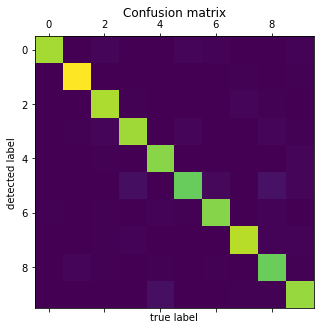

Accuracy:  0.9442
The 10 most mislabeled pairs are:
[5, 8] 0.54 %
[9, 4] 0.46 %
[5, 3] 0.4 %
[5, 6] 0.22 %
[5, 9] 0.18 %
[3, 8] 0.18 %
[4, 9] 0.17 %
[8, 1] 0.15 %
[2, 7] 0.15 %
[3, 5] 0.14 %


0.9442

In [12]:
perc.accuracy(test_data[0],test_data[1],1)

## Grid search

To fine-tune our model we will perform a grid search for the following hyperparameters:
- learning rate
- size of hidden layers
- number of hidden layers 

We will assume that the number of epochs brings an increase in accuracy as the number of epochs increases regardless of 
the other parameters, so we will only try increasing number of epochs once we have found the best values for the rest of 
parameters, and we will stop once the accuracy plateaus.

In [47]:
def Grid_Search(parameters,training_data,training_labels,validation_data,validation_labels):
    #parameters is a dict with the name of the parameter as key and the possible values as value
    #parameters = {'Learning_Rate': [],
    #              'Number of Hidden Layers': [],
    #              'Number of nodes in a hidden layer': []
    #             }
    
    accuracy = []
    
    inputlayer = [training_data.shape[1]]
    outputlayer = [max(training_labels)+1]
    for i,nhd in enumerate(parameters['Number of Hidden Layers']):
        accuracy.append({})
        #list of list with all the combinations of number of nodes for every hidden layer
        combinations = comb_rep_n(nhd,parameters['Number of nodes in a hidden layer'])
        for comb in combinations:
            layers = inputlayer + comb + outputlayer
            perc = Perceptron(layers)
            for lr in parameters['Learning_Rate']:
                batch = 5
                perc.train(training_data,training_labels,lr,batch,nepoch)
                acc = perc.accuracy(validation_data,validation_labels)
                accuracy[i].update( {'hidden layers:'+str(nhd)+':'+str(comb)+',lr:'+str(lr):acc} )
    return accuracy

def add_1_of_each(lili,B):
    lol = []
    for li in lili:
        for m in range(len(B)):
            li.append(B[m])
            licopy = li[:]
            lol.append(licopy)
            li.pop(-1)
    return lol

def comb_rep_n(n,B,inp=[[]]):
    for k in range(n):
        inp = add_1_of_each(inp,B)
    return inp


The first set of hyperparameters we will use for a grid search are:

In [48]:
parameters = {'Learning_Rate': [0.0001,0.001,0.01,0.1],
              'Number of Hidden Layers': [0,1,2],
              'Number of nodes in a hidden layer': [10,20,40,60,80]
             }
#the total number of trials is 
#( sum_nhd (len(nn)^nhd) )* len(nlr)
#(5^0 + 5^1 + 5^2) * 4 = 124

In [49]:
start = time.time()
accuracy_dict = Grid_Search(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
print('It took ', time.time()-start, ' seconds')

It took  315.23011207580566  seconds


And now we will display the results of the grid search, separated based on the number of hidden layers, plotting the accuracy for every combination of numbers of nodes, with a different line for every learning rate. 

In [68]:
def disp_gs_results(accuracy_dict,lr_or_ne):
#the results are separated based on the number of hidden layers, and the accuracy is plotted for every combination of
#the number of nodes, with every line representing a different learning rate or number of training epochs. 
    L = len(accuracy_dict)
    nodes = []
    accuracy = []
    diflr = [] #named diflr but works for both lr and nepochs
    n_layers = []
    for h in range(L):
        nodes.append([])
        accuracy.append([])
        diflr.append([])
        for key in accuracy_dict[h].keys():
            spl = key.split(':')
            nhl = int(spl[1])
            if nhl not in n_layers:
                n_layers.append(nhl)
            num_nodes = spl[2][:-3]
            num_nodes = num_nodes.replace(",",",\n")
            accu = accuracy_dict[h][key]
            lr = float(spl[3])
            if lr not in diflr[h]:
                diflr[h].append(lr)
                nodes[h].append([])
                accuracy[h].append([])
            lridx = diflr[h].index(lr)
            nodes[h][lridx].append(num_nodes)
            accuracy[h][lridx].append(accu)

    fig, ax = plt.subplots(L,1,figsize=(15,15))
    for h in range(L):
        for i in range(len(diflr[h])):
            if lr_or_ne == 'lr':
                lab = "lr = "+str(diflr[h][i])
            if lr_or_ne == 'ne':
                lab = "n epochs = "+str(diflr[h][i])
            if n_layers[h] == 0:
                ax[h].plot(nodes[h][i], accuracy[h][i], marker = 'o', label = lab)
            else:
                ax[h].plot(nodes[h][i], accuracy[h][i], label = lab)    
        #ax[h].set_ylim([0,1])
        ax[h].set_title('Accuracy for '+str(n_layers[h])+' layers')
        ax[h].set_xlabel('Nodes on the hidden layers')
        ax[h].set_ylabel('Accuracy')    
        ax[h].legend()
    plt.show()
#len(beta_list) is however many plots you have, so L = len(accuracy_dict)

#num_columns = 3
#fig, ax = plt.subplots(divmod(L,num_columns)[0],num_columns,figsize=(15,15))
#for b in range(L):
#    im=ax[divmod(b,3)[0],divmod(b,3)[1]].imshow(thrs_dist[b],origin='lower',extent=(GAthrs[0],GAthrs[-1],AEthrs[0],AEthrs[-1]),aspect='auto',cmap=plt.cm.Blues)
#    ax[divmod(b,3)[0],divmod(b,3)[1]].set_xlabel('GA')
#    ax[divmod(b,3)[0],divmod(b,3)[1]].set_ylabel('AE')
#    ax[divmod(b,3)[0],divmod(b,3)[1]].set_title('beta = '+str(beta_list[b]))
#    fig.colorbar(im)
#plt.show()

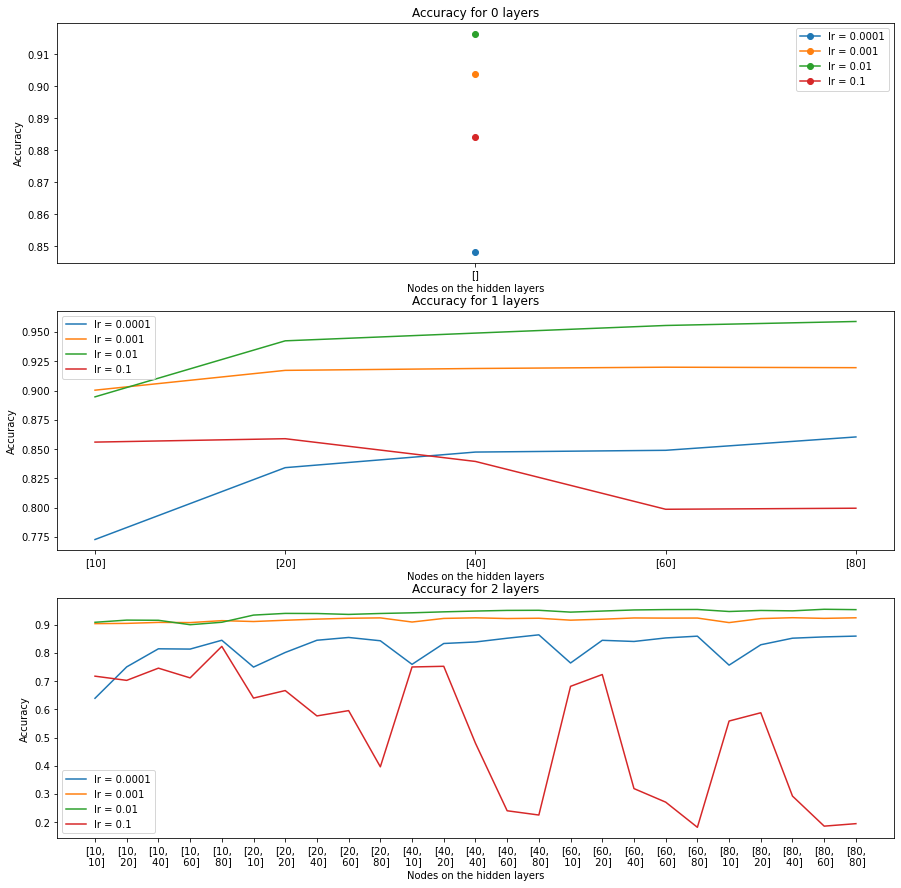

In [130]:
#import gs_2 for this example 
with open('gs_2.pkl', 'rb') as f:
    accuracy_dict, parameters, time = pickle.load(f)
disp_gs_results(accuracy_dict,'lr')

We can see in the graphs that
- the best learning rates are 0.01 and 0.001
- accuracy goes up with the number of nodes for 1 and 2 layers

But we would need a comparison between lr 0.01 for 0, 1 and 2 layers to see if the number of layers makes a difference 

In [84]:
def compare_lr_ne(accuracy_dict,bestlr): #bestlr is a list of the best learning rate or n epochs for every number of layers
    L = len(accuracy_dict)
    nodes = []
    accuracy = []
    diflr = []
    n_layers = []
    for h in range(L):
        nodes.append([])
        accuracy.append([])
        diflr.append([])
        for key in accuracy_dict[h].keys():
            spl = key.split(':')
            nhl = int(spl[1])
            if nhl not in n_layers:
                n_layers.append(nhl)
            num_nodes = spl[2][:-3]
            num_nodes = num_nodes.replace(",",",\n")
            accu = accuracy_dict[h][key]
            lr = float(spl[3])
            if lr not in diflr[h]:
                diflr[h].append(lr)
                nodes[h].append([])
                accuracy[h].append([])
            lridx = diflr[h].index(lr)
            nodes[h][lridx].append(num_nodes)
            accuracy[h][lridx].append(accu)

    fig, ax = plt.subplots(1,1,figsize=(12,6))
    for h,maxlr in zip(range(L),bestlr):
        i = diflr[h].index(maxlr)
        xdummy = np.linspace(0,100,len(nodes[h][i]))
        if n_layers[h] == 0:
            ax.plot(xdummy, accuracy[h][i], marker = 'o', label = "number of layers = "+str(n_layers[h]))    
        else:
            ax.plot(xdummy, accuracy[h][i], label = "number of layers = "+str(n_layers[h]))    
    #ax.set_ylim([0,1])
    ax.set_title('Accuracy for the highest lr or epoch')
    ax.set_xlabel('no units')
    ax.set_ylabel('Accuracy')    
    ax.legend()
    plt.show()

In [135]:
def print_best_models(accuracy_dict):
    #prints the model with the higher accuracy for every line
    L = len(accuracy_dict)
    nodes = []
    accuracy = []
    diflr = []
    n_layers = []
    for h in range(L):
        nodes.append([])
        accuracy.append([])
        diflr.append([])
        for key in accuracy_dict[h].keys():
            spl = key.split(':')
            nhl = int(spl[1])
            if nhl not in n_layers:
                n_layers.append(nhl)
            num_nodes = spl[2][:-3]
            #num_nodes = num_nodes.replace(",",",\n")
            accu = accuracy_dict[h][key]
            lr = float(spl[3])
            if lr not in diflr[h]:
                diflr[h].append(lr)
                nodes[h].append([])
                accuracy[h].append([])
            lridx = diflr[h].index(lr)
            nodes[h][lridx].append(num_nodes)
            accuracy[h][lridx].append(accu)

    for h in range(L):
        for lrid in range(len(diflr[h])):
            nid = accuracy[h][lrid].index(max(accuracy[h][lrid]))
            print('lr or ne',diflr[h][lrid],'hidden layer nodes',nodes[h][lrid][nid],'accuracy',max(accuracy[h][lrid]))

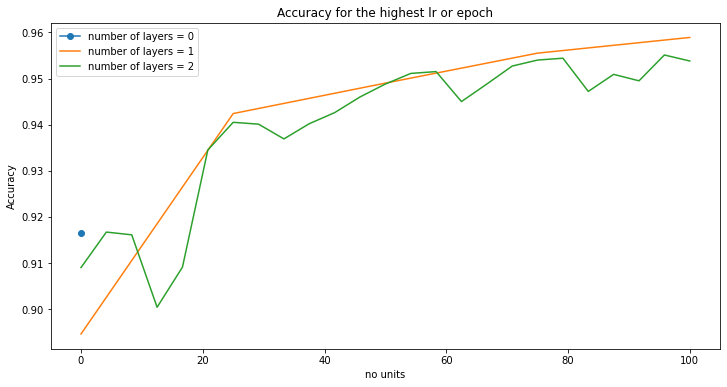

In [133]:
#import gs_2 for this example
compare_lr_ne(accuracy_dict,[0.01,0.01,0.01])

In [134]:
print_best_models(accuracy_dict)

lr or ne 0.0001 hidden layer nodes [] accuracy 0.8483
lr or ne 0.001 hidden layer nodes [] accuracy 0.9038
lr or ne 0.01 hidden layer nodes [] accuracy 0.9164
lr or ne 0.1 hidden layer nodes [] accuracy 0.8842
lr or ne 0.0001 hidden layer nodes [80] accuracy 0.8604
lr or ne 0.001 hidden layer nodes [60] accuracy 0.9199
lr or ne 0.01 hidden layer nodes [80] accuracy 0.9589
lr or ne 0.1 hidden layer nodes [20] accuracy 0.8589
lr or ne 0.0001 hidden layer nodes [40, 80] accuracy 0.8645
lr or ne 0.001 hidden layer nodes [80, 40] accuracy 0.9252
lr or ne 0.01 hidden layer nodes [80, 60] accuracy 0.9551
lr or ne 0.1 hidden layer nodes [10, 80] accuracy 0.8236


We can see that for both 1 and 2 layers the accuracy is similar, and 0 layers performs worse, as expected. Moreover it still increases when the number of nodes increases,  so we will try another grid search, this time with:
- 1, 2, 3 hidden layers.  Since 1 and 2 performed similarly we want to see what happens when we add more layers
- more nodes on the hidden layers, since accuracy was directly proportional to the number of nodes, starting from 80
- learning rates closer to 0.01 and 0.001 since they perform the best

Now the parameters look like

In [18]:
parameters = {'Learning_Rate': [0.001,0.005,0.01,0.05],
              'Number of Hidden Layers': [1,2,3],
              'Number of nodes in a hidden layer': [80,100,120]
             }
#the total number of trials is 
#( sum_nhd (len(nn)^nhd) )* len(nlr)
#(3^1 + 3^2 + 3^3) * 4 = 156

In [126]:
start = time.time()
accuracy_dict = Grid_Search(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
print('It took ', time.time()-start, ' seconds')

It took  1617.4240837097168  seconds


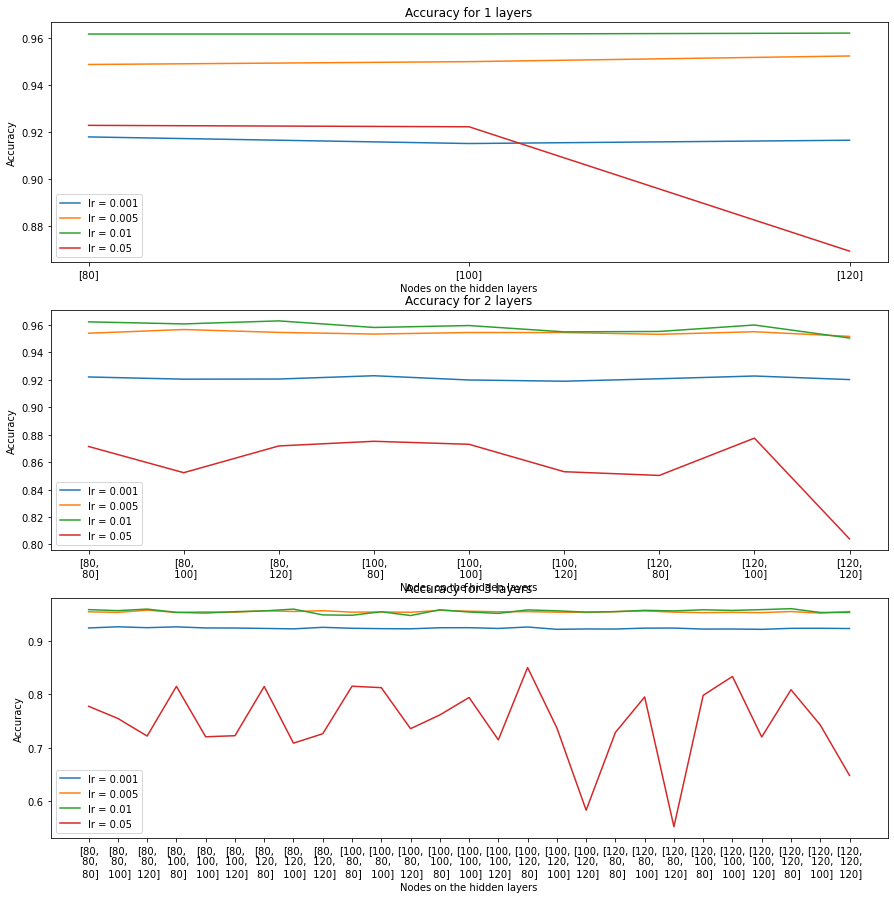

In [127]:
#import gs_3 for this example
with open('gs_3.pkl', 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'lr')

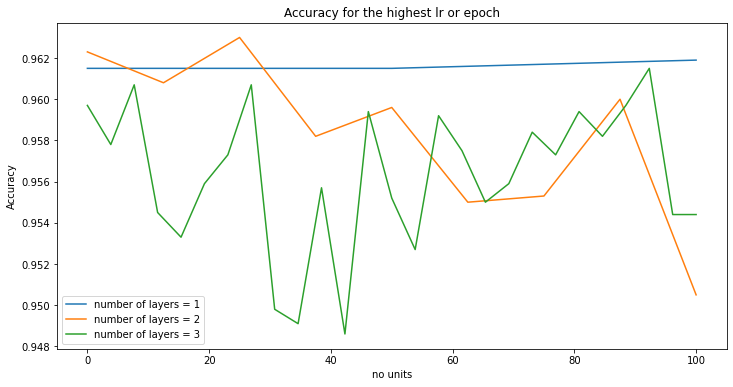

In [128]:
#gs_3
compare_lr_ne(accuracy_dict,[0.01,0.01,0.01])

This seems to indicate, somewhat counterintuitively, that the accuracy of the model doesn't go up as the number of layers goes up, and it instead diminishes.

However this results were obtained with only a max of 120 nodes per hidden layer and using only 1 training epoch. 
Changing the number of training epochs might be important for networks with more layers, so it will be our next pursuit. 
Initially, we assumed the number of epochs affected the performance of the model equally for all structures, but these results might indicate otherwise, so now we will add the number of training epochs as a hyperparameter in the gridsearch. 

But first we will look at our current best models.

In [129]:
#gs_3
print_best_models(accuracy_dict)

lr or ne 0.001 hidden layer nodes [80] accuracy 0.9179
lr or ne 0.005 hidden layer nodes [120] accuracy 0.9522
lr or ne 0.01 hidden layer nodes [120] accuracy 0.9619
lr or ne 0.05 hidden layer nodes [80] accuracy 0.9228
lr or ne 0.001 hidden layer nodes [100, 80] accuracy 0.923
lr or ne 0.005 hidden layer nodes [80, 100] accuracy 0.9567
lr or ne 0.01 hidden layer nodes [80, 120] accuracy 0.963
lr or ne 0.05 hidden layer nodes [120, 100] accuracy 0.8775
lr or ne 0.001 hidden layer nodes [80, 80, 100] accuracy 0.9274
lr or ne 0.005 hidden layer nodes [80, 80, 120] accuracy 0.9586
lr or ne 0.01 hidden layer nodes [120, 120, 80] accuracy 0.9615
lr or ne 0.05 hidden layer nodes [100, 120, 80] accuracy 0.8507


We can see the best models are
- \[80,120] lr = 0.01 for an accuracy of 0.963 
- \[120] lr = 0.01 for an accuracy of 0.9619
- \[120,120,80] lr = 0.01 for an accuracy of 0.9615

This shows that 0.01 is the best learning rate we have tried yet and that the number of layers is not very relevant at least for number of nodes in the 80-120 range and 1 training epoch.

Now we will do the next grid search, this time adding a new parameter n_epochs. For simplicity we will be doing another grid search function that assumes the learning rate to be a constant and has the number of epochs as a hyperparameter since otherwise it would be hard to iterate and visualize the results. 

We can still use the same visualization functions as long as we change the labels accordingly. 

In [86]:
def Grid_Search_epoch(parameters,training_data,training_labels,validation_data,validation_labels):
    #parameters is a dict with the name of the parameter as key and the possible values as value
    #parameters = {'Learning_Rate': 0
    #              'Number of  training epochs': [],
    #              'Number of Hidden Layers': [],
    #              'Number of nodes in a hidden layer': []
    #             }
    
    accuracy = []
    
    inputlayer = [training_data.shape[1]]
    outputlayer = [max(training_labels)+1]
    
    lr = parameters['Learning_Rate']

    for i,nhd in enumerate(parameters['Number of Hidden Layers']):
        accuracy.append({})
        #list of list with all the combinations of number of nodes for every hidden layer
        combinations = comb_rep_n(nhd,parameters['Number of nodes in a hidden layer'])
        for comb in combinations:
            layers = inputlayer + comb + outputlayer
            perc = Perceptron(layers)
            for nepoch in parameters['Number of  training epochs']:
                batch = 5
                perc.train(training_data,training_labels,lr,batch,nepoch)
                acc = perc.accuracy(validation_data,validation_labels)
                accuracy[i].update( {'hidden layers:'+str(nhd)+':'+str(comb)+',ep:'+str(nepoch):acc} )
    return accuracy

Now we can perform our new grid search with parameters

In [87]:
parameters = {'Learning_Rate': 0.01,
              'Number of  training epochs': [1,2,3],
              'Number of Hidden Layers': [1,2,3],
              'Number of nodes in a hidden layer': [80,100,120]
             }
#the total number of trials is      (assuming 1 epoch 1 trial, 2 epochs 2 trials)
#( sum_nhd (len(nn)^nhd) )* sum(nte)
#(3^1 + 3^2 + 3^3) * 6 = 234

In [24]:
start = time.time()
accuracy_dict = Grid_Search_epoch(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
print('It took ', time.time()-start, ' seconds')

It took  1072.918049812317  seconds


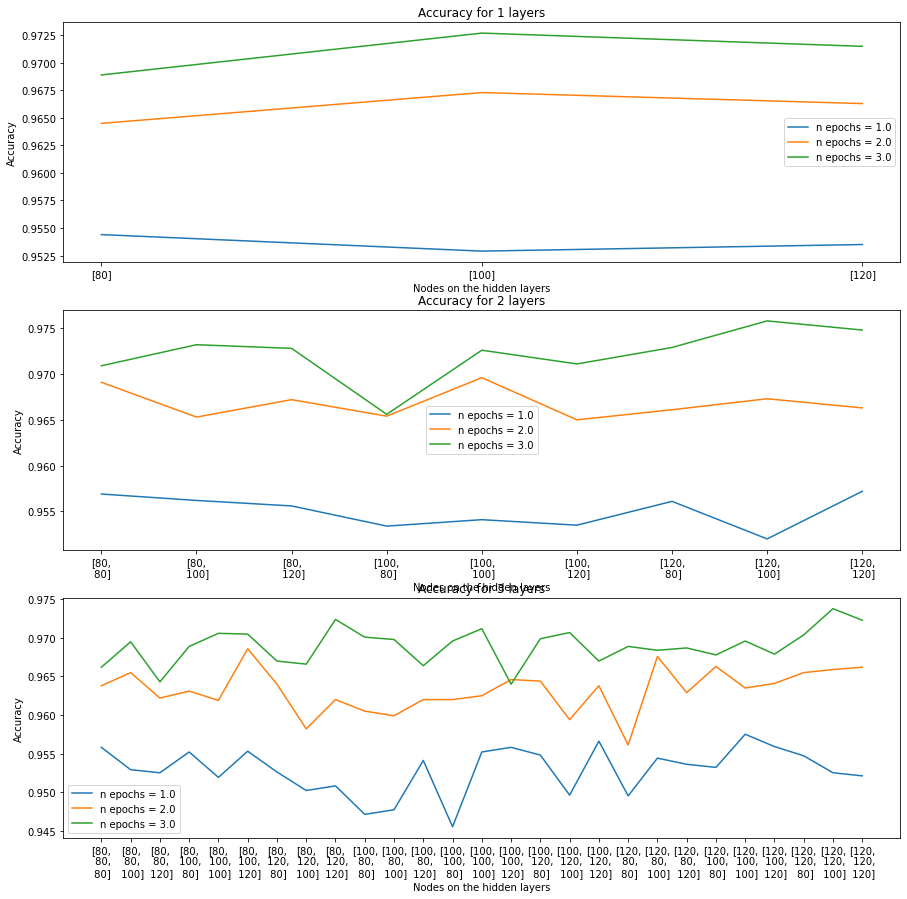

In [155]:
#gse_1
with open('gse_1.pkl', 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'ne')

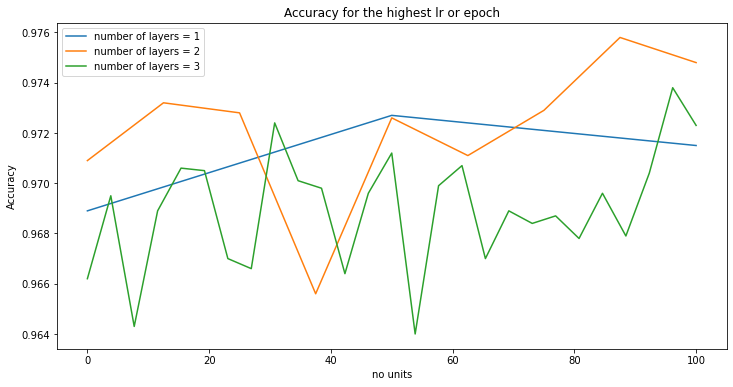

In [138]:
#gse_1
compare_lr_ne(accuracy_dict,[3,3,3])

In [156]:
print_best_models(accuracy_dict)

lr or ne 1.0 hidden layer nodes [80] accuracy 0.9544
lr or ne 2.0 hidden layer nodes [100] accuracy 0.9673
lr or ne 3.0 hidden layer nodes [100] accuracy 0.9727
lr or ne 1.0 hidden layer nodes [120, 120] accuracy 0.9572
lr or ne 2.0 hidden layer nodes [100, 100] accuracy 0.9696
lr or ne 3.0 hidden layer nodes [120, 100] accuracy 0.9758
lr or ne 1.0 hidden layer nodes [120, 100, 100] accuracy 0.9575
lr or ne 2.0 hidden layer nodes [80, 100, 120] accuracy 0.9686
lr or ne 3.0 hidden layer nodes [120, 120, 100] accuracy 0.9738


Now we see, as expected, that more training epochs bring higher accuracy across all networks, and not only that, but the 2 and 3 hidden layers networks start to outperform the 1 hidden layer network more often. 

Now for our final parameters we will try to increase the number of epochs and nodes to see if we can go a bit further. 

In [91]:
parameters = {'Learning_Rate': 0.01,
              'Number of  training epochs': [3,4,5],
              'Number of Hidden Layers': [1,2,3],
              'Number of nodes in a hidden layer': [120,150,180]
             }
#the total number of trials is      (assuming 1 epoch 1 trial, 2 epochs 2 trials)
#( sum_nhd (len(nn)^nhd) )* sum(nte)
#(3^1 + 3^2 + 3^3) * 12 = 468

In [92]:
start = time.time()
accuracy_dict = Grid_Search_epoch(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
print('It took ', time.time()-start, ' seconds')

It took  3905.7488312721252  seconds


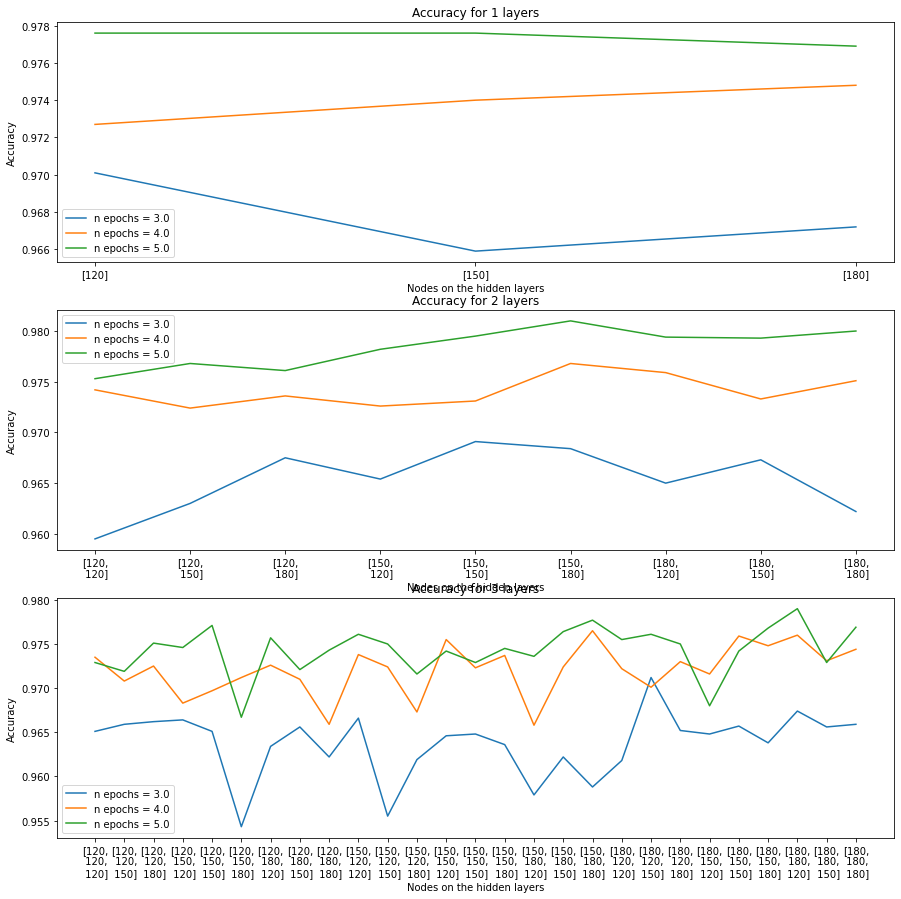

In [144]:
#gse_2
with open('gse_2.pkl', 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'ne')

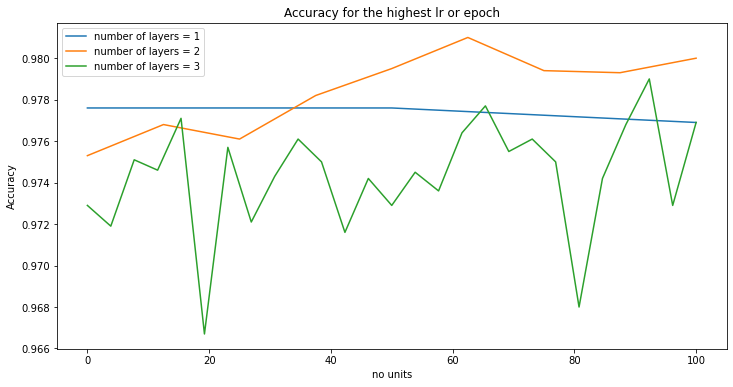

In [145]:
#gse_2
compare_lr_ne(accuracy_dict,[5,5,5])

We can see here that 2 layers seems to be performing the best. Additionally, 1 layer has reached a plateau.
Still, 2 and 3 layers still seem to be getting better as the number of nodes and training epochs increase, so we will do a final grid search with 2 and 3 layers, with higher epochs and number of nodes. 

In [146]:
#gse_2
print_best_models(accuracy_dict)

lr or ne 3.0 hidden layer nodes [120] accuracy 0.9701
lr or ne 4.0 hidden layer nodes [180] accuracy 0.9748
lr or ne 5.0 hidden layer nodes [120] accuracy 0.9776
lr or ne 3.0 hidden layer nodes [150, 150] accuracy 0.9691
lr or ne 4.0 hidden layer nodes [150, 180] accuracy 0.9768
lr or ne 5.0 hidden layer nodes [150, 180] accuracy 0.981
lr or ne 3.0 hidden layer nodes [180, 120, 150] accuracy 0.9712
lr or ne 4.0 hidden layer nodes [150, 180, 180] accuracy 0.9765
lr or ne 5.0 hidden layer nodes [180, 180, 120] accuracy 0.979


We can see that as of now, our best models are
- \[150,180] 5 epochs for an accuracy of 0.981
- \[180,180,120] 5 epochs for an accuracy of 0.979
- \[120] 5 epochs for an accuracy of 0.9776
- \[150,180] 4 epochs for an accuracy of 0.9768

The final grid search with 2 and 3 layers, with higher epochs and number of nodes will have parameters

In [103]:
parameters = {'Learning_Rate': 0.01,
              'Number of  training epochs': [6,7,8],
              'Number of Hidden Layers': [2,3],
              'Number of nodes in a hidden layer': [200,250,300]
             }
#the total number of trials is      (assuming 1 epoch 1 trial, 2 epochs 2 trials)
#( sum_nhd (len(nn)^nhd) )* sum(nte)
#(3^2 + 3^3) * 21 = 756

In [104]:
start = time.time()
accuracy_dict = Grid_Search_epoch(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
print('It took ', time.time()-start, ' seconds')

It took  41078.03154659271  seconds


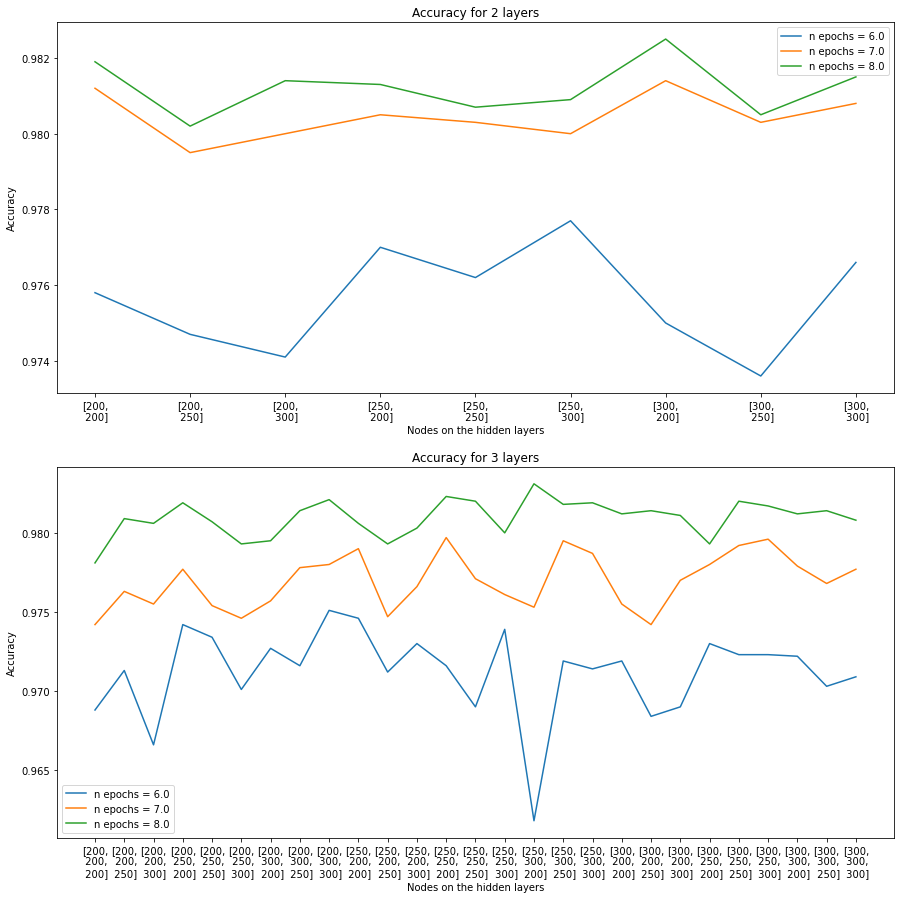

In [157]:
#gse_3
with open('gse_3.pkl', 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'ne')

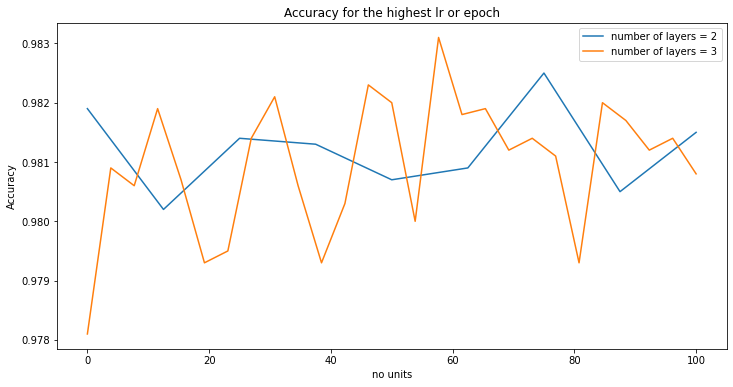

In [158]:
compare_lr_ne(accuracy_dict,[8,8])

Finally, we see that the accuracy has hit a maximum at least for the number of nodes or layers, and only seems to experience a slight increase when increasing the number of epochs. So we will finally decide on the best structure for our model. To make the best decision we will compare the best models of each grid search and choose. 

In [149]:
print_best_models(accuracy_dict)

lr or ne 6.0 hidden layer nodes [250, 300] accuracy 0.9777
lr or ne 7.0 hidden layer nodes [300, 200] accuracy 0.9814
lr or ne 8.0 hidden layer nodes [300, 200] accuracy 0.9825
lr or ne 6.0 hidden layer nodes [200, 300, 300] accuracy 0.9751
lr or ne 7.0 hidden layer nodes [250, 250, 200] accuracy 0.9797
lr or ne 8.0 hidden layer nodes [250, 300, 200] accuracy 0.9831


For gs_2
- \[80]     lr = 0.01 ne = 1 for an accuracy of 0.9589
- \[80, 60] lr = 0.01 ne = 1 for an accuracy of 0.9551

For gs_3
- \[80,120]     lr = 0.01 ne = 1 for an accuracy of 0.963 
- \[120]        lr = 0.01 ne = 1 for an accuracy of 0.9619
- \[120,120,80] lr = 0.01 ne = 1 for an accuracy of 0.9615

For gse_1
- \[120, 100]      lr = 0.01 ne = 3 accuracy 0.9758
- \[120, 120, 100] lr = 0.01 ne = 3 accuracy 0.9738
- \[100]           lr = 0.01 ne = 3 accuracy 0.9727


For gse_2
- \[150,180]     lr = 0.01 ne = 5 for an accuracy of 0.981
- \[180,180,120] lr = 0.01 ne = 5 for an accuracy of 0.979
- \[120]         lr = 0.01 ne = 5 for an accuracy of 0.9776
- \[150,180]     lr = 0.01 ne = 4 for an accuracy of 0.9768

For gse_3
- \[250, 300, 200] lr = 0.01 ne = 8 accuracy 0.9831
- \[300, 200]      lr = 0.01 ne = 8 accuracy 0.9825
- \[300, 200]      lr = 0.01 ne = 7 accuracy 0.9814


In [118]:
#Compare performance with AI for beginners' method

#If this grid search finds that a certain number of layers is the best, we might want to do a final grid search around the 0.01 
#learning rate using the best performing models and increase number of epochs.

In [152]:
# Saving the objects:
def saving_gs_results(acc_dict,parameters,filename='gs_1'):
    
    if not os.path.isfile(filename+'.pkl'): #file doesn't exist, save it
        with open(filename+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump([acc_dict,parameters], f)
        print('saved')
    else: 
        yesno = input('the file '+filename+' already exists, want to rewrite it? (y/n) ')
        if yesno == 'y':
            with open(filename+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([acc_dict,parameters], f)
            print('rewritten')
        else:
            print('not rewritten')
            pass

#Getting back the objects:
#with open('gs_2.pkl', 'rb') as f:
#    accuracy_dict, parameters, time = pickle.load(f)

In [154]:
saving_gs_results(accuracy_dict,parameters,'gse_3')

the file gse_3 already exists, want to rewrite it? (y/n) n
not rewritten


In [ ]:
#gs_1 is the trial gridsearch
#gs_2 is the first serious gridsearch 315.23 s
#gs_3 the second serious gridsearch 1617.42 s
#gse_1 is the first gridsearch with training epochs instead of lr 1072.91 s
#gse_2 3905.74 s
#gse_3 more than 4 hours aprox

___

# Using AI for beginners' method

For building a perceptron framework we need 5 elements, which will be in the form of classes:

- linear transformation
- hidden layer activation function
- softmax activation function
- loss function ??????????????????????????
- stackable network framework

All element except the network framework have a forward pass to calculate the probabilities of the classes and a backward pass to calculate the derivatives of the weights through backpropagation. 
The loss function is a cross entropy function and the output layer uses a softmax activation function, since that is what I assumed for my mathematical resolution, but any hidden layer activation function can be used. In particular I will be using tanh since it is a simple function to differentiate. 


In [274]:
class Linear:

    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (output_dimension,input_dimension))
        self.b = np.zeros((output_dimension))        

    def forward(self,x): 
        return np.dot(self.W,x) + self.b 

    def backward(self):
        return 
    
x = np.array([1,-2,0,-1,2])
lll = Linear(5,3)
print(lll.forward(x))

[-0.88184657 -0.74112329 -0.16958856]


In [276]:
class Softmax:
    def forward(self,z):
        expz = np.exp(z)
        Z = expz.sum(keepdims=True)
        self.p = expz / Z
        return self.p

    def backward(self):
        return 1

softm = Softmax()
print(softm.forward(x))

[0.23412166 0.01165623 0.08612854 0.03168492 0.63640865]


In [277]:
class Activation_function:
    def forward(self,z):
        self.y = np.tanh(z)
        return self.y #tanh squishes values between -1 and 1 

activ = Activation_function()
activ.forward(x)

array([ 0.76159416, -0.96402758,  0.        , -0.76159416,  0.96402758])

In [278]:
class loss_function:
    def forward(self,p,labels):
        p_of_true = p[np.arange(len(labels)), labels]
        return -np.log(p_of_true).mean()

crossloss = loss_function()
p = np.array([[0.01,0.1,0.7,0.1,0.05,0.04],[0.84,0.01,0.01,0.05,0.05,0.04]])
l = np.array([2,0])
crossloss.forward(p,l) 

#Might be better as a function since I am not calling it to calculate derivatives only the loss itself, so it gets called only 
#once at the end of the training epoch or training process

0.2655141655417551

_____

## Training

In [39]:
#%matplotlib nbagg
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random

In [35]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Split into train and test dataset
train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [36]:
#in progress
net = Network()
net.add(Output_Layer(2,2))
learning_rate = 0.1


pred = np.argmax(net.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Initial accuracy: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]
    
    # forward pass
    #z = lin.forward(xb)
    #p = softmax.forward(z)
    #loss = cross_ent_loss.forward(p,yb)
    
    p = net.forward(xb)
    
    
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    #dp = cross_ent_loss.backward(loss)
    #dz = softmax.backward(dp)
    #dx = lin.backward(dz)
    #lin.update(learning_rate)
    
pred = np.argmax(net.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Final accuracy: ",acc)


Initial accuracy:  0.2125
Final accuracy:  0.825


_____

In [ ]:
#class definition in progress for (784,) as input vector
class Hidden_Layer_singlevec():
    def __init__(self,input_dimension,output_dimension,batch):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (output_dimension,input_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
    def linear_forward(self,x):
        self.yn_1 = x                       #storing y(n-1) for later
        return np.dot(self.W,x) + self.b    #returns the linear transformation
    
    def activation_forward(self,z):
        y = np.tanh(z)
        self.da = 1-y*y                     #storing a'(n) for layer
        return y                            #tanh squishes values between -1 and 1
    
    def backward(self,A_prev):
        #calculate A of this layer
        #AN1 = np.matmul(WN1.T,np.multiply(AN,a'N1))
        
        #calculate derivatives of this layer using An_1
        #np.matmul(np.multiply(AN,a'N1),yN2.T)
        #np.multiply(AN,a'N1)
        
        #store derivatives but not any A since they are fed as inputs
        
        #return A
        
        Ada = np.multiply(A_prev,self.da)
        
        A = np.matmul(self.W.T,Ada)
        
        dW = np.matmul(Ada,self.yn_1.T)
        db = Ada
        
        #takes An as input
        #calculates and stores derivatives
        #returns An-1
        
        return A
        
    def update(lr):
        #the derivatives are already stored
        #remember the - signs that can be removed
        
        #change W and b by derivatives no returning anything
        
        
        
hid = Hidden_Layer(5,3)
print(1-hid.activation_forward(hid.linear_forward(x))*hid.activation_forward(hid.linear_forward(x)),hid.da)
